# Ill-posedness: An illustrative example

## 1D Inverse Heat Equation

An illustrative example of ill-posedness is the inversion for the initial condition for a one-dimensional heat equation.

Specifically, we consider a rod of length $L$, and let $u(x,t)$ denote the temperature of the rod at point $x$ and time $t$. 
We are interested in reconstructing the initial temperature profile $m(x) = u(x, 0)$ given some noisy measurements $d$ of the temperature profile at a later time $T$.

### Forward problem

Given
- the initial temperature profile $u(x,0) = m(x)$,
- the thermal diffusivity $k$,
- a prescribed temperature $u(0,t) = u(L,t) = 0$ at the ends of the rod,

solve the heat equation

$$
\left\{
\begin{array}{ll}
\frac{\partial u}{\partial t} - k \frac{\partial^2}{\partial x^2} u = 0 & \forall x\,\in\,(0, L)\; \forall t \in (0,T)\\
u(x, 0) = m(x) & \forall x \in [0,L] \\
u(0,t) = u(L,t) = 0 & \forall t \in (0, T],
\end{array}
\right.
$$

and observe the temperature at the final time $T$:

$$ \mathcal{F}(m) = u(x, T). $$

#### Analytical solution to the forward problem
Verify that if

$$ m(x) = \sin\left(i\, \frac{\pi}{L} x \right), \quad i = 1,2,3, \ldots ,$$

then

$$ u(x,t) = e^{ -k\left(i\, \frac{\pi}{L} \right)^2 t} \sin\left(i\,\frac{\pi}{L} x \right) $$

is the unique solution to the heat equation.

### Inverse problem

Given the forward model $\mathcal{F}$ and a noisy measurement $d$ of the temperature profile at time $T$, find the initial temperature profile $m$ such that

$$ \mathcal{F}(m) = d. $$

### Ill-posedness of the inverse problem

Consider a perturbation

$$ \delta m(x) = \varepsilon \sin\left(i \, \frac{\pi}{L} x \right), $$

where $\varepsilon > 0$ and $i = 1, 2, 3, \ldots$.

Then, by linearity of the forward model $\mathcal{F}$, the corresponding perturbation $\delta d(x) = \mathcal{F}(m + \delta m) - \mathcal{F}(m)$ is

$$ \delta d(x) = \varepsilon\, e^{ -k\left(i \, \frac{\pi}{L}\right)^2 T} \sin\left(i \, \frac{\pi}{L} x \right),$$

which converges to zero as $i \rightarrow +\infty$.

Hence the ratio between $\delta m$ and $\delta d$ can become arbitrary large, which shows that the stability requirement for well-posedness can not be satisfied.

### Discretization

To discretize the problem, we use finite differences in space and Implicit Euler in time.

#### Semidiscretization in space
We divide the $[0, L]$ interval in $n_x$ subintervals of the same lenght $h = \frac{L}{n_x}$, and we denote with $u_j(t) := u( jh, t)$ the value of the temperature at point $x_j = jh$ and time $t$.

We then use a centered finite difference approximation of the second derivative in space and write

$$ \frac{\partial u_j(t)}{\partial t} - k \frac{u_{j-1}(t) - 2u_j(t) + u_{j+1}(t)}{h^2} \quad \text{for } j=1,2,\ldots,n_x-1,$$

with the boundary condition $u_0(t) = u_{n_x}(t) = 0$.

We let $n = n_x-1$ be the number of discretization points in the interior of the interval $[0, L]$, and let 

$$ \mathbf{u}(t) = \begin{bmatrix}u_1(t)\\u_2(t)\\ \ldots\\ u_{n_x-1}(t) \end{bmatrix} \in \mathbb{R}^n $$

be the vector collecting the values of the temperature $u(x,t)$ at the points $x_j = j\,h$ with $j=1,\ldots,n_x-1$.

We then write the system of ordinary differential equations (ODEs):
$$ \frac{\partial}{\partial t} \mathbf{u}(t) + K \mathbf{u}(t) = 0,$$
where $K \in \mathbb{R}^{n \times n}$ is the tridiagonal matrix given by

$$ K = \frac{k}{h^2}\begin{bmatrix}  2 & -1 &       &        &        &    \\
                                    -1 &  2 & -1    &        &        &    \\
                                       & -1 &  2    & -1     &        &    \\
                                       &    &\ldots & \ldots & \ldots &    \\
                                       &    &       & -1     &     2  & -1 \\ 
                                       &    &       &        &     -1 & 2  \\
                     \end{bmatrix}.$$
                     
#### Time discretization
We subdivide the time interval $(0, T]$ in $n_t$ time step of size $\Delta t = \frac{T}{n_t}$.
By letting $\mathbf{u}^{(i)} = \mathbf{u}(i\,\Delta t)$ denote the discretized temperature profile at time $t_i = i\,\Delta t$, the Implicit Euler scheme reads

$$ \frac{\mathbf{u}^{(i+1)} - \mathbf{u}^{(i)}}{\Delta t} + K\mathbf{u}^{(i+1)} = 0, \quad \text{for } i=0,1,\ldots, n_t-1.$$

After simple algebraic manipulations and exploiting the initial condition $u(x,0) = m(x)$, we then obtain

$$
\left\{
\begin{array}
\mathbf{u}^{(0)} = \mathbf{m} \\
\mathbf{u}^{(i+1)} = \left( I + \Delta t\, K\right)^{-1} \mathbf{u}^{(i)},
\end{array}
\right.
$$

or equivalently

$$ \mathbf{u}^{(i)} = \left( I + \Delta t\, K\right)^{-i} \mathbf{m}.$$

In the code below, the function `assembleMatrix` generates the finite difference matrix $\left( I + \Delta t\, K \right)$ and the function `solveFwd` evaluates the forward model

$$ F\, \mathbf{m} = \left( I + \Delta t\, K\right)^{-n_t}\, \mathbf{m}. $$

In [13]:
from __future__ import print_function, absolute_import, division

import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline

def plot(f, style, **kwargs):
    x = np.linspace(0., L, nx+1)
    f_plot = np.zeros_like(x)
    f_plot[1:-1] = f
    plt.plot(x,f_plot, style, **kwargs)
    
def assembleMatrix(k, h, dt, n):
    diagonals = np.zeros((3, n))   # 3 diagonals
    diagonals[0,:] = -1.0/h**2
    diagonals[1,:] =  2.0/h**2
    diagonals[2,:] = -1.0/h**2
    K = k*sp.spdiags(diagonals, [-1,0,1], n,n)
    M = sp.spdiags(np.ones(n), 0, n,n)
    
    return M + dt*K
    

def solveFwd(m, k, h, dt, n, nt):
    A = assembleMatrix(k, h, dt, n)
    u_old = m.copy()
    for i in np.arange(nt):
        u = la.spsolve(A, u_old)
        u_old[:] = u
        
    return u        

### A naive solution to the inverse problem

If $\mathcal{F}$ is invertible a naive solution to the inverse problem $\mathcal{F} m = d$ is simply to set

$$ m = \mathcal{F}^{-1} d. $$

The function `naiveSolveInv` computes the solution of the discretized inverse problem $\mathbf{m} = F^{-1} \mathbf{d}$ as

$$ \mathbf{m} = \left( I + \Delta t\,K\right)^{n_t} \mathbf{d}. $$

The code below shows that:
- for a very coarse mesh (`nx = 20`) and no measurement noise (`noise_std_dev = 0.0`) the naive solution is quite good
- for a finer mesh (`nx = 100`) and/or even small measurement noise (`noise_std_dev = 1e-4`) the naive solution is garbage

In [14]:
def naiveSolveInv(d, k, h, dt, n, nt):
    A = assembleMatrix(k, h, dt, n)
    
    p_i = d.copy()
    for i in np.arange(nt):
        p = A*p_i
        p_i[:] = p
        
    return p

T = 1.0
L = 1.0
k = 0.005

Very coarse mesh and no measurement noise


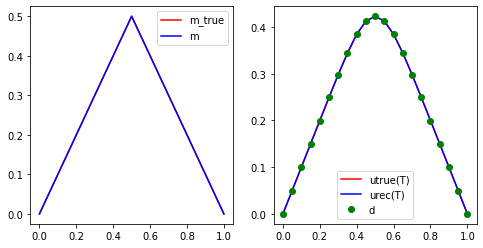

In [15]:
print("Very coarse mesh and no measurement noise")
nx = 20
nt = 100

noise_std_dev = 0.

h = L/float(nx)
dt = T/float(nt)

x = np.linspace(0.+h, L-h, nx-1) #place nx-1 equispace point in the interior of [0,L] interval
m_true = 0.5 - np.abs(x-0.5)
u_true = solveFwd(m_true, k, h, dt, nx-1, nt)

d = u_true + noise_std_dev*np.random.randn(u_true.shape[0])

m = naiveSolveInv(d, k, h, dt, nx-1, nt)
u_rec = solveFwd(m, k, h, dt, nx-1, nt)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plot(m_true, "-r", label = 'm_true')
plot(m, "-b", label = 'm')
plt.legend()
plt.subplot(1,2,2)
plot(u_true, "-r", label = 'utrue(T)')
plot(u_rec, "-b", label = 'urec(T)')
plot(d, "og", label = 'd')
plt.legend()
plt.show()

Fine mesh and small measurement noise


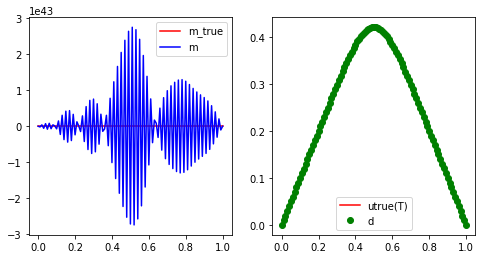

In [16]:
print("Fine mesh and small measurement noise")
nx = 100
nt = 100

noise_std_dev = 1.e-4

h = L/float(nx)
dt = T/float(nt)

x = np.linspace(0.+h, L-h, nx-1) #place nx-1 equispace point in the interior of [0,L] interval
m_true = 0.5 - np.abs(x-0.5)
u_true = solveFwd(m_true, k, h, dt, nx-1, nt)

d = u_true + noise_std_dev*np.random.randn(u_true.shape[0])

m = naiveSolveInv(d, k, h, dt, nx-1, nt)
u_rec = solveFwd(m, k, h, dt, nx-1, nt)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plot(m_true, "-r", label = 'm_true')
plot(m, "-b", label = 'm')
plt.legend()
plt.subplot(1,2,2)
plot(u_true, "-r", label = 'utrue(T)')
#plot(u_rec, "-b", label = 'urec(T)')
plot(d, "og", label = 'd')
plt.legend()
plt.show()

### Why does the naive solution fail?

#### Spectral property of the parameter to observable map

Let $v_i = \sqrt{\frac{2}{L}} \sin\left( i \, \frac{\pi}{L} x \right)$ with $i=1,2,3, \ldots$, then we have that

$$ \mathcal{F} v_i = \lambda_i v_i, \quad \text{where the eigenvalues } \lambda_i = e^{-kT\left(\frac{\pi}{L} i \right)^2}. $$

**Note**:
- Large eigenvalues $\lambda_i$ corresponds to smooth eigenfunctions $v_i$;
- Small eigenvalues $\lambda_i$ corresponds to oscillatory eigenfuctions $v_i$.

The figure below shows that the eigenvalues $\lambda_i$ of the continuous parameter to obervable map $\mathcal{F}$ decays extremely (exponentially) fast.

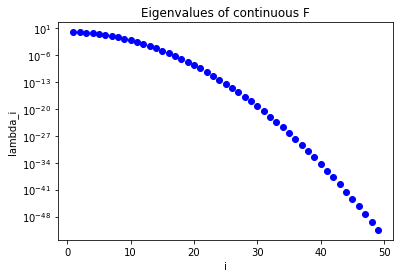

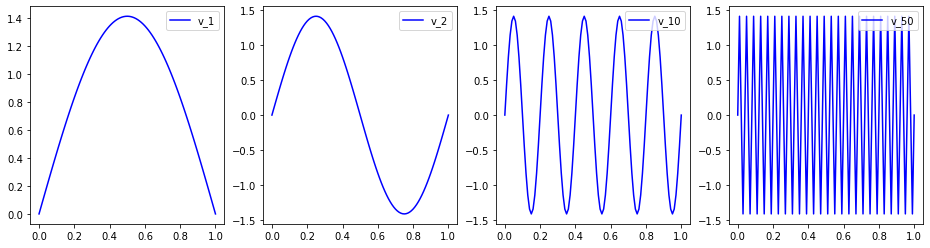

In [17]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

T = 1.0
L = 1.0
k = 0.005

#nx = 20
#h = L/float(nx)
#x = np.linspace(0.+h, L-h, nx-1) #place nx-1 equispace point in the interior of [0,L] interval

i = np.arange(1,50)
lambdas = np.exp(-k*T*np.power(np.pi/L*i,2))

v1  = np.power(2/L,0.5)*np.sin(1*np.pi/L*x)
v2  = np.power(2/L,0.5)*np.sin(2*np.pi/L*x)
v10 = np.power(2/L,0.5)*np.sin(10*np.pi/L*x)
v50 = np.power(2/L,0.5)*np.sin(50*np.pi/L*x)

plt.semilogy(i, lambdas, 'ob')
plt.xlabel('i')
plt.ylabel('lambda_i')
plt.title("Eigenvalues of continuous F")
plt.show()

plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plot(v1, "-b", label = 'v_1')
plt.legend()
plt.subplot(1,4,2)
plot(v2, "-b", label = 'v_2')
plt.legend()
plt.subplot(1,4,3)
plot(v10, "-b", label = 'v_10')
plt.legend()
plt.subplot(1,4,4)
plot(v50, "-b", label = 'v_50')
plt.legend()
plt.show()


In a similar way, the figure below show the eigenvalues of the discrete parameter to observable map $F$: their fast decay means that $F$ is extremely ill conditioned.

In the code below we assemble the matrix $F$ column-by-column, by computing its actions on the canonical vectors 
$$\mathbf{m}_i = \begin{bmatrix} 0 \\ \ldots \\ 0\\ 1 \\ 0\\ \ldots \\0 \end{bmatrix}, \quad i = 1,\ldots,n,$$
where the $i$th entry is the only non-zero component of $\mathbf{m}_i$.

> **Disclaimer**: $F$ is a large dense implicitly defined operator and should never be built explicitly for a real problem (since it would require $\mathcal{O}(n)$ evaluations of the forward problem and $\mathcal{O}( n^2)$ storage); instead --- as you will learn later this week --- scalable algorithms for the solution of the inverse problem only require the ability to compute the action of $F$ on a few given directions $\mathbf{m}$.

nx =  100


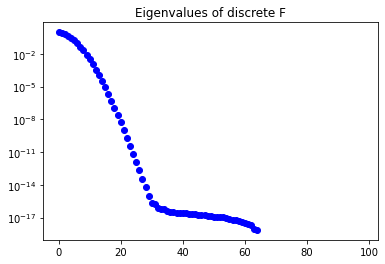

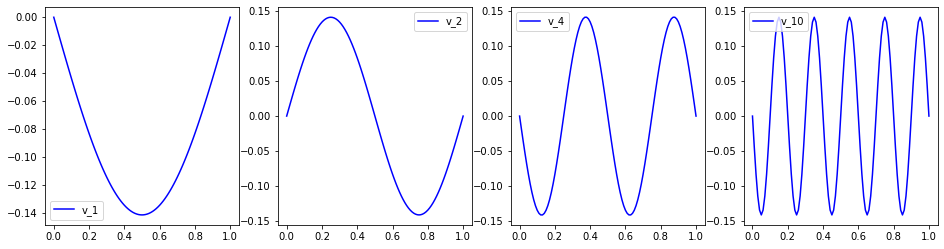

In [18]:
def computeEigendecomposition(k, h, dt, n, nt):
    ## Compute F as a dense matrix
    F = np.zeros((n,n))
    m_i = np.zeros(n)
    
    for i in np.arange(n):
        m_i[i] = 1.0
        F[:,i] = solveFwd(m_i, k, h, dt, n, nt)
        m_i[i] = 0.0
    
    ## solve the eigenvalue problem
    lmbda, U = np.linalg.eigh(F)
    ## sort eigenpairs in decreasing order
    lmbda[:] = lmbda[::-1]
    lmbda[lmbda < 0.] = 0.0
    U[:] = U[:,::-1]
    
    return lmbda, U 

print("nx = ", nx)
## Compute eigenvector and eigenvalues of the discretized forward operator
lmbda, U = computeEigendecomposition(k, h, dt, nx-1, nt)

plt.semilogy(lmbda, 'ob')
plt.title("Eigenvalues of discrete F")
plt.show()

v1  = U[:,0]
v2  = U[:,1]
v4  = U[:,3]
v10 = U[:,9]

plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plot(v1, "-b", label = 'v_1')
plt.legend()
plt.subplot(1,4,2)
plot(v2, "-b", label = 'v_2')
plt.legend()
plt.subplot(1,4,3)
plot(v4, "-b", label = 'v_4')
plt.legend()
plt.subplot(1,4,4)
plot(v10, "-b", label = 'v_10')
plt.legend()
plt.show()

#### Informed and uninformed modes

The functions $v_i$ ($i=1,2,3, \ldots$) form an orthonormal basis of $L^2([0,1])$. 

That is, every function $f \in L^2([0,1])$ can be written as

$$ f = \sum_{i=1}^\infty \alpha_i v_i, \text{ where } \alpha_i = \int_0^1 f v_i dx.$$

Consider now the noisy problem

$$ d = \mathcal{F}\,m_{\rm true} + \eta, $$

where
- $d$ is the data (noisy measurements)
- $\eta$ is the noise: $\eta(x) = \sum_{n=1}^\infty \eta_n v_n(x)$
- $m_{\rm true}$ is the true value of the parameter that generated the data
- $\mathcal{F}$ is the forward heat equation

Then, the naive solution to the inverse problem $\mathcal{F}m = d$ is

$$ m = \mathcal{F}^{-1}d = \mathcal{F}^{-1}\left( \mathcal{F}\,m_{\rm true} + \eta \right) = m_{\rm true} + \mathcal{F}^{-1} \eta = m_{\rm true} + \mathcal{F}^{-1} \sum_{i=1}^{\infty} \eta_i v_i = m_{\rm true} +  \sum_{i=1}^{\infty} \frac{\eta_i}{\lambda_i} v_i. $$

If the coefficients $\eta_i = \int_0^1 \eta(x) \, v_i(x) \, dx$ do not decay sufficiently fast with respect to the eigenvalues $\lambda_i$, then the naive solution is unstable.

This implies that oscillatory components can not reliably be reconstructed from noisy data since they correspond to small eigenvalues.

### Tikhonov regularization

The remedy is to find a parameter $m$ that solves the inverse problem $\mathcal{F}\, m = d$ in a *least squares sense*.
Specifically, we solve the minimization problem

$$ \min_m \frac{1}{2} \int_0^L (\mathcal{F}\, m - d )^2 dx + \frac{\alpha}{2} \mathcal{R}(m), $$

where the Tikhonov regularization $\mathcal{R}(m)$ is a quadratic functional of $m$.
In what follow, we will penalize the $L^2$-norm of the initial condition and let $\mathcal{R}(m) = \int_0^L m^2 dx$. However other choices are possible; for example by penalizing the $L^2$-norm of the gradient of $m$ ($\mathcal{R}(m) = \int_0^L m_x^2$), one will favor smoother solutions.

The regularization parameter $\alpha$ needs to be chosen appropriately. If $\alpha$ is small, the computation of the initial condition $m$ is unstable as in the naive approach. On the other hand, if $\alpha$ is too large, information is lost in the reconstructed $m$. Various criteria --- such as Morozov's discrepancy principle or L-curve criterion  --- can be used to find the optimal amount of regularization (see the **Hands on** section).

#### Morozov's discrepancy principle

The discrepancy principle, due to Morozov, chooses the regularization parameter to be the largest value of $\alpha$ such that the norm of the misfit is bounded by the noise level in the data, i.e.,

$$ \| \mathcal{F}\,m_\alpha - d \| \leq \delta, $$ 

where $\delta$ is the noise level. Here, $m_\alpha$ denotes the parameter found minimizing the Tikhonov regularized minimization problem with parameter $\alpha$. This choice aims to avoid overfitting of the data, i.e., fitting the noise.

#### L-curve criterion

Choosing $\alpha$ parameter using the L-curve criterion requires the solution of inverse problems for a sequence of regularization parameters. Then, for each $\alpha$, the norm of the data misfit (also called residual) $\| \mathcal{F}\,m_\alpha - d \|$ is plotted against the norm of the regularization term $\|m_\alpha\|$ in a log-log plot.
This curve usually is found to be L-shaped and thus has an *elbow*, i.e. a point of greatest curvature. The L-curve criterion chooses the regularization parameter corresponding to that point. The idea behind the L-curve criterion is that this choice for the regularization parameter is a good compromise between fitting the data and controlling the stability of the parameters. A smaller $\alpha$, which correspond to points to the left of the optimal value, only leads to a slightly better data fit while significantly increasing the norm of the parameters. Conversely, a larger $\alpha$, corresponding to points to the right of the optimal value, slightly decrease the norm of the solution, but they increase the data misfit significantly.


### Discretization
In the discrete setting, the Tikhonov regularized solution $\mathbf{m}_{\alpha}$ solves the penalized least squares problem

$$ \min_{\mathbf{m}} \frac{1}{2} \| F\, \mathbf{m} - \mathbf{d} \|^2 + \frac{\alpha}{2} \| \mathbf{m} \|^2, $$

where $\| \cdot \|$ denotes the Euclidean vector norm in $\mathbb{R}^n$.

$\mathbf{m}_{\alpha}$ can then be computed by solving the normal equations

$$ ( F^t F + \alpha I) \mathbf{m}_{\alpha} = F^t \mathbf{d}.$$

The code below, find the Tikhonov regularized solution $\mathbf{m}_{\alpha}$ for $\alpha = 10^{-3}$.

> **Disclaimer**: In the code below, for simplicity, we explicitly construct and factorize the matrix $F^t F + \alpha I$. This approach is not feasible and should **never** be used to solve real problems (the computational cost is  $\mathcal{O}(n^3)$). Instead, as we will see tomorrow, one should solve the normal equations using the conjugate gradient algorithm, which only requires the ability to compute the action of $F^t F + \alpha I$ on a few given directions $\mathbf{m}$, and is guaranteed to converge in a number of iterations that is independent of $n$.

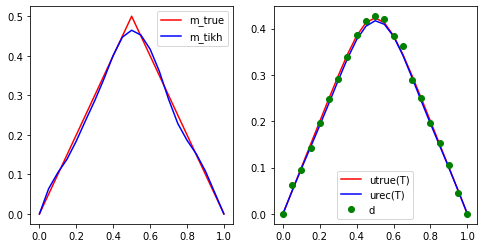

In [19]:
def assembleF(k, h, dt, n, nt):
    F = np.zeros((n,n))
    m_i = np.zeros(n)
    
    for i in np.arange(n):
        m_i[i] = 1.0
        F[:,i] = solveFwd(m_i, k, h, dt, n, nt)
        m_i[i] = 0.0

    return F

def solveTikhonov(d, F, alpha):    
    H = np.dot( F.transpose(), F) + alpha*np.identity(F.shape[1])
    rhs = np.dot( F.transpose(), d)
    return np.linalg.solve(H, rhs)

## Setup the problem
T = 1.0
L = 1.0
k = 0.005

nx = 20
nt = 100

noise_std_dev = 1e-2

h = L/float(nx)
dt = T/float(nt)

## Compute the data d by solving the forward model
x = np.linspace(0.+h, L-h, nx-1)
#m_true = np.power(.5,-36)*np.power(x,20)*np.power(1. - x, 16)
m_true = 0.5 - np.abs(x-0.5)
u_true = solveFwd(m_true, k, h, dt, nx-1, nt)
d = u_true + noise_std_dev*np.random.randn(u_true.shape[0])

alpha = 0.02

F = assembleF(k, h, dt, nx-1, nt)
m_alpha = solveTikhonov(d, F, alpha)
u_rec = solveFwd(m_alpha, k, h, dt, nx-1, nt)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plot(m_true, "-r", label = 'm_true')
plot(m_alpha, "-b", label = 'm_tikh')
plt.legend()
plt.subplot(1,2,2)
plot(u_true, "-r", label = 'utrue(T)')
plot(u_rec, "-b", label = 'urec(T)')
plot(d, "og", label = 'd')
plt.legend()
plt.show()


## Hands on

## Problem 1: Spectrum of the parameter to observable map

### Question a:
Set $T=1$, $L=1$, $n_x = 200$, and $n_t = 100$, and plot the
decay of the eigenvalues of both the continuous ($\mathcal{F}$) and
the discrete ($F$) parameter-to-observable maps as a function of the index $i$.

Do this for the following values of $k$: 0.0001, 0.001, 0.01, 0.1, 1.0 (all on the same plot).

### Question b:
Set $L=1$, $k = 0.01$ and $T=0.1$; plot the decay of the discrete eigenvalues as a function of $n_x, n_t$ for different resolutions in the space and time discretization. 

Use $(n_x, n_t) = (20, 20), (40, 40), (80,80), (160, 160)$.

What do you observe as you increase the resolution? 

## Problem 2: Tikhonov Regularization

Consider the same inverse heat equation problem above
with $L=1$, $T=0.1$, $k=0.01$.

Discretize the problem using $n_x = 200$ intervals in space and $n_t = 100$ time steps.

As initial condition use the (discrete version of) the true initial temperature profile 

$$
m_{\text{true} } = \max(0, 1 - |1 - 4x|) + 100\, x^{10}(1-x)^2.
$$

Use the code below to implement the above function in Python:
```
import numpy as np
x = np.arange(1,n_x, dtype=np.float64)*h
m_true = np.maximum( np.zeros_like(x), 1. - np.abs(1. - 4.*x)) \
         + 100.*np.power(x,10)*np.power(1.-x,2)
```

Add normally distributed noise $\mathbf{n}$ with mean zero and
variance $\sigma^2 = 10^{-4}$. The resulting noisy observation of the
final time temperature profile is $\mathbf{d} = F \mathbf{m} + \mathbf{n}$.

### Question a
Use Tikhonov regularization with $\alpha = 0.0001,0.001,0.01,0.1,1$ to compute the regularized
reconstructions $\mathbf{m}_\alpha$.

### Question b
Determine the (approximate) optimal value of the regularization parameter $\alpha$ in the Tikhonov regularization using the L-curve criterion.

### Question c
Determine the (approximate) optimal value of the regularization parameter $\alpha$ in the Tikhonov regularization 
using Morozov's discrepancy criterion, i.e., find the largest value of $\alpha$ such that 

$$
\|F\,\mathbf{m}_\alpha - \mathbf{d}\| \le \delta
$$

where $\delta=\| \mathbf{n}\|$ and $\mathbf{m}_\alpha$ is the solution of the Tikhonov-regularized inverse problem with regularization parameter $\alpha$.

### Question d
Plot the  $L_2$ norm error in the reconstruction, $\|\mathbf{m}_{\text{true}}-\mathbf{m}_\alpha\|$, as a function of $\alpha$, where $\mathbf{m}_\alpha$ is the Tikhonov regularized solution. Which value of $\alpha$ (approximately) minimizes this error? Compare the *optimal* values of $\alpha$ obtained using the L-curve and Morozov's discrepancy criterion.

## Problem 3: Tikhonov regularization on the gradient of $m$

Consider the Tikhonov regularized solution $m_\alpha$ where we penalize the norm of the *gradient* of $m$.
That is, $m_\alpha$ solves minimization problem

$$ \min_m \frac{1}{2} \int_0^L (\mathcal{F}\, m - d )^2 dx + \frac{\alpha}{2} \int_0^L m_x^2 \, dx. $$

### Question a

Discretize and solve the inverse problem using the same parameters and true initial condition as in Problem 2.

### Question b

Determine the *optimal* amount of regularization using either the L-curve criterion or the discrepancy principle.
How does this solution differs from the one computed in Problem 2?


Copyright &copy; 2018, The University of Texas at Austin & University of California, Merced. All Rights reserved. See file COPYRIGHT for details.

This file is part of the hIPPYlib library. For more information and source code availability see https://hippylib.github.io.

hIPPYlib is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License (as published by the Free Software Foundation) version 2.0 dated June 1991.